# Particle independent Metropolis-Hastings (PIMH)

Notebook about testing the PIMH algorithm.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [43]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.pmcmc.pimh import ParticleIndependentMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

First we work with the Linear Gaussian model.

In [44]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=1.0,
    sigma_y=0.5,
)

# Initialize model
model = LGModel(rng=rng)

In [45]:
T = 100

x_true, y = simulate_data(model, theta, T, rng)

In [46]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [47]:
N = 400

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

history = bpf.run(y, theta)
trajectories = bpf.smoothing_trajectories(history)

In [48]:
n_traj = len(trajectories)   # number of trajectories

# Initialize arrays
x_array = np.zeros((n_traj, T+1))        # for x_t, +1 to include t=0

# Fill arrays
for i, traj in enumerate(trajectories):
    for t in range(T+1):
        x_array[i, t] = traj[t].x_t      # LGM latent


In [49]:
x_mean = x_array.mean(axis=0)  # mean across trajectories for each time step

In [50]:
logliks = []
for _ in range(200):
    history = bpf.run(y, theta)
    logliks.append(history[-1][3])

np.var(logliks)
print(f"Variance of log-likelihood estimates: {np.var(logliks):.4f}")

Variance of log-likelihood estimates: 0.7874


In [53]:
# Now we run the PIMH algorithm
pimh = ParticleIndependentMetropolisHastings(bpf)
samples, logliks = pimh.run(y, theta, n_iter=1000, burnin=0, verbose=True)

Iteration 10/1000, Acceptance Rate: 0.444
Iteration 20/1000, Acceptance Rate: 0.316
Iteration 30/1000, Acceptance Rate: 0.414
Iteration 40/1000, Acceptance Rate: 0.436
Iteration 50/1000, Acceptance Rate: 0.449
Iteration 60/1000, Acceptance Rate: 0.458
Iteration 70/1000, Acceptance Rate: 0.435
Iteration 80/1000, Acceptance Rate: 0.506
Iteration 90/1000, Acceptance Rate: 0.528
Iteration 100/1000, Acceptance Rate: 0.505
Iteration 110/1000, Acceptance Rate: 0.505
Iteration 120/1000, Acceptance Rate: 0.504
Iteration 130/1000, Acceptance Rate: 0.519
Iteration 140/1000, Acceptance Rate: 0.532
Iteration 150/1000, Acceptance Rate: 0.523
Iteration 160/1000, Acceptance Rate: 0.497
Iteration 170/1000, Acceptance Rate: 0.509
Iteration 180/1000, Acceptance Rate: 0.525
Iteration 190/1000, Acceptance Rate: 0.508
Iteration 200/1000, Acceptance Rate: 0.503
Iteration 210/1000, Acceptance Rate: 0.493
Iteration 220/1000, Acceptance Rate: 0.502
Iteration 230/1000, Acceptance Rate: 0.507
Iteration 240/1000, 

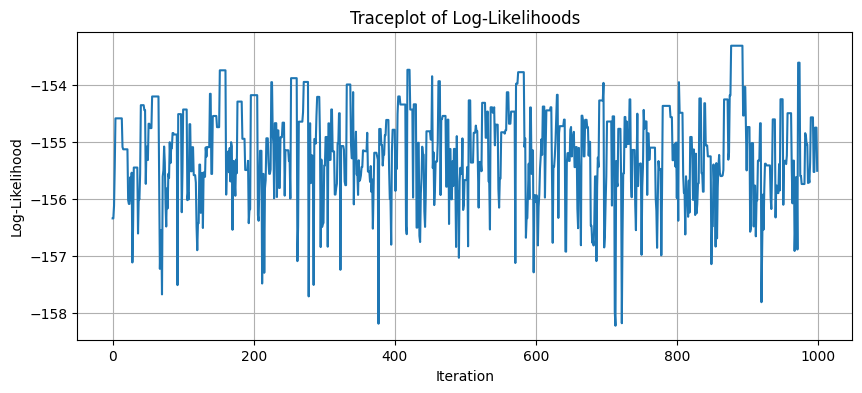

In [54]:
# Traceplot of log-likelihoods
plt.figure(figsize=(10, 4))
plt.plot(logliks)
plt.title('Traceplot of Log-Likelihoods')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()